In [1]:
import sys, time, os
sys.path.append("..")

from utils.Db import Db
import pandas as pd
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime 
from datetime import timedelta
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from utils.kalman_utils import pool_init, run_kalman, DEAD
from multiprocessing import Queue
from multiprocessing.pool import Pool


plt.rcParams["figure.figsize"] = [9, 6]
%matplotlib notebook

In [2]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()
yearsFmt = mdates.DateFormatter('%Y')

db = Db("../cache")
df = db.get_symbols_as_dataframe(['AAPL'])
df['date_time'] = pd.to_datetime(df['date_time'])

# Support Vector Regression

Can fit a line exactly to the data

In [3]:
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
dates = df['unix_time'].as_matrix()
dates = np.reshape(dates, (len(dates), 1))
prices = df['adjusted_close'].as_matrix()
svr_rbf.fit(dates, prices)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

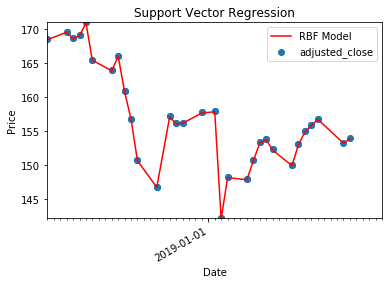

In [4]:
fig, ax = plt.subplots()
ax.scatter(df['date_time'].as_matrix(), df['adjusted_close'])
ax.plot(df['date_time'].as_matrix(), svr_rbf.predict(dates), color='red', label='RBF Model')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_minor_locator(days)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
left = df.tail(60)['date_time'].dt.to_pydatetime()[0]
right = df.tail(1)['date_time'].dt.to_pydatetime()[0] + timedelta(days=5)
ax.set_xlim(left=left, right=right)
bottom = df.tail(60)['adjusted_close'].min()
top = df.tail(60)['adjusted_close'].max()
ax.set_ylim(top=top, bottom=bottom)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

# Kalman Filter

Uses the equations of kinematics to predict motion in the X direction. Will track the movement very close to the data.

In [5]:
kalman_data = df[['unix_time', 'adjusted_close', 'date_time']].as_matrix()
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([
    [kalman_data[0][1]],
    [0.0]
], dtype=float)
kf.F = np.array([
    [1., 1.],
    [0., 1.]
])
kf.H = np.array([[1., 0.]])
kf.P *= 1000.
kf.R = 5
kf.Q = Q_discrete_white_noise(2, 1., .1)

data_2 = [kf.x[0][0]]
for x in kalman_data[1:]:        
    kf.predict()
    kf.update(np.array([[x[1]]], dtype=float))
    val = kf.x[0][0]   
    data_2.append(val)

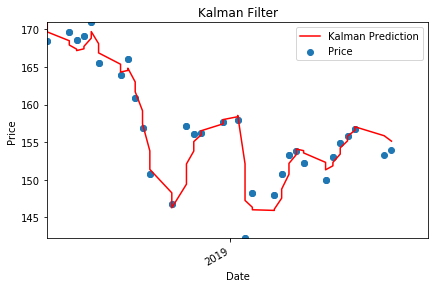

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)

x_vals = kalman_data[:,2]
y_vals = kalman_data[:,1].tolist()
ax.scatter(x_vals, y_vals, label='Price')
ax.plot(x_vals, data_2, label='Kalman Prediction', color='red')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
left = kalman_data[-60,2]
right = kalman_data[-1,2] + timedelta(days=5)
ax.set_xlim(left=left, right=right)
bottom = kalman_data[-60:,1].min()
top = kalman_data[-60:,1].max()
ax.set_ylim(top=top, bottom=bottom)
fig.tight_layout()
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Kalman Filter')
plt.legend()    

# Predict one week using Kalman Filter

Showing the last 60 days. Using the entire dataset to build the kalman filter. Predicting values for the next 5 days. 

In [7]:
last_few = kalman_data[-60:,:]

unix_dates = last_few[:,0].reshape(-1, 1)
x_vals = last_few[:,2]
y_vals = last_few[:,1].tolist()

last_few_kalman = data_2[-60:]
next_vals = [last_few_kalman[-1]]
next_dates = [x_vals[-1]]
last_date = last_few[-1,2]

for i in range(5):
    kf.predict()
    kval = kf.x[0][0]
    next_date = last_date + timedelta(days=i+1)
    next_vals.append(kval)
    next_dates.append(next_date)

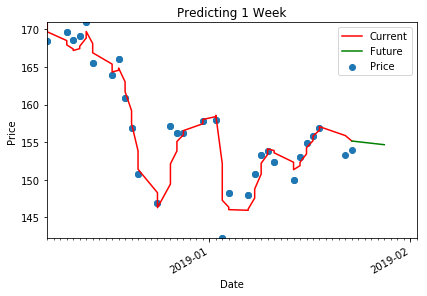

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_vals, y_vals, label='Price')
ax.plot(x_vals, last_few_kalman, label='Current', color='red')
ax.plot(next_dates, next_vals, label='Future', color='green')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_minor_locator(days)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
left = last_few[0,2]
right = last_few[-1,2] + timedelta(days=10)
ax.set_xlim(left=left, right=right)
bottom = last_few[:,1].min()
top = last_few[:,1].max()
ax.set_ylim(top=top, bottom=bottom)
fig.tight_layout()
fig.autofmt_xdate()
plt.title('Predicting 1 Week')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Predict 5 days ahead and 30 days ahead

In [9]:
def run_kalman_future(future):
    queue = Queue()
    pool = Pool(initializer=pool_init, initargs=(queue,), processes=os.cpu_count())
    
    pool_args = []
    for i in range(1, len(kalman_data)):
        if i % future == 0:
            pool_args.append((i, future, kalman_data))

    pool.map(run_kalman, pool_args)

    returned = 0
    results = []
    while True:
        out = queue.get(True)
        if out != DEAD:
            results.append(list(out))
        returned += 1
        if returned == len(pool_args):
            break
    results = sorted(results, key=lambda x: x[0])
    df = pd.DataFrame(results, columns=['row', 'date_time', 'prediction', 'error'])
    
    pool.close()
    return df['date_time'].as_matrix(), df['prediction'].as_matrix(), df['error'].as_matrix()

In [10]:
# kalman_pd5, kalman_p5, kalman_e5 = run_kalman(5)
if __name__ == '__main__':
    kalman_pd5, kalman_p5, kalman_e5 = run_kalman_future(5)

Mean prediction Error: 1.22624728078
Std prediction Error: 2.1062133644


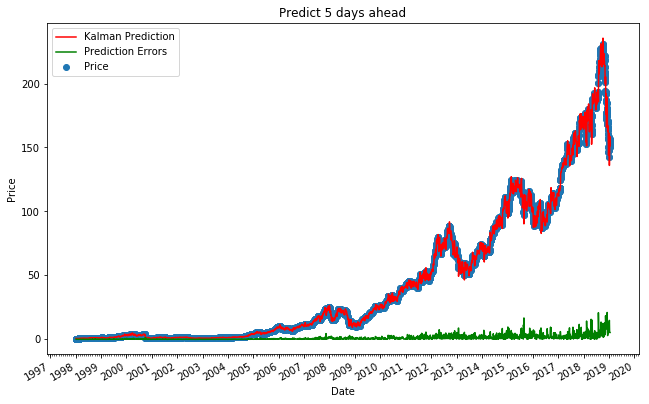

In [11]:
plt.rcParams["figure.figsize"] = [9, 6]

fig = plt.figure()
ax = fig.add_subplot(111)

x_vals = kalman_data[:,2]
y_vals = kalman_data[:,1].tolist()
ax.scatter(x_vals, y_vals, label='Price')
ax.plot(kalman_pd5, kalman_p5, label='Kalman Prediction', color='red')
ax.plot(kalman_pd5, kalman_e5, label='Prediction Errors', color='green')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
fig.tight_layout()
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predict 5 days ahead')
plt.legend() 


print("Mean prediction Error: " + str(np.mean(np.array(kalman_e5))))
print("Std prediction Error: " + str(np.std(kalman_e5)))

In [12]:
if __name__ == '__main__':
    kalman_pd30, kalman_p30, kalman_e30 = run_kalman_future(30)

Mean prediction Error: 4.95345717986
Std prediction Error: 7.99255210843


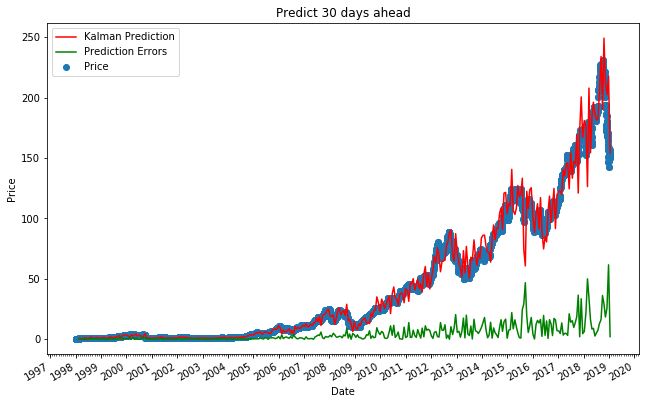

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

x_vals = kalman_data[:,2]
y_vals = kalman_data[:,1].tolist()
ax.scatter(x_vals, y_vals, label='Price')
ax.plot(kalman_pd30, kalman_p30, label='Kalman Prediction', color='red')
ax.plot(kalman_pd30, kalman_e30, label='Prediction Errors', color='green')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
fig.tight_layout()
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predict 30 days ahead')
plt.legend() 

print("Mean prediction Error: " + str(np.mean(np.array(kalman_e30))))
print("Std prediction Error: " + str(np.std(kalman_e30)))